In [1]:
%matplotlib inline

import time
import datetime

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from scipy.optimize import curve_fit
from jupyterthemes import jtplot

jtplot.style(theme='onedork')

In [2]:
# Data from:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [3]:
df = pd.read_csv(url, index_col=[0,1])
df

Lat       Long  \
Province/State                   Country/Region                         
NaN                              Afghanistan     33.000000  65.000000   
                                 Albania         41.153300  20.168300   
                                 Algeria         28.033900   1.659600   
                                 Andorra         42.506300   1.521800   
                                 Angola         -11.202700  17.873900   
...                                                    ...        ...   
                                 Botswana       -22.328500  24.684900   
                                 Burundi         -3.373100  29.918900   
                                 Sierra Leone     8.460555 -11.779889   
Bonaire, Sint Eustatius and Saba Netherlands     12.178400 -68.238500   
NaN                              Malawi         -13.254308  34.301525   

                                                 1/22/20  1/23/20  1/24/20  \
Province/State                   Country/Region                              
NaN                              Afghanistan           0        0        0   
                                 Albania               0        0        0   
                                 Algeria               0        0        0   
                                 Andorra               0        0        0   
                                 Angola                0        0        0   
...                                                  ...      ...      ...   
                                 Botswana              0        0        0   
                                 Burundi               0        0        0   
                                 Sierra Leone          0        0        0   
Bonaire, Sint Eustatius and Saba Netherlands           0        0        0   
NaN                              Malawi                0        0        0   

                                                 1/25/20  1/26/20  1/27/20  \
Province/State                   Country/Region                              
NaN                              Afghanistan           0        0        0   
                                 Albania               0        0        0   
                                 Algeria               0        0        0   
                                 Andorra               0        0        0   
                                 Angola                0        0        0   
...                                                  ...      ...      ...   
                                 Botswana              0        0        0   
                                 Burundi               0        0        0   
                                 Sierra Leone          0        0        0   
Bonaire, Sint Eustatius and Saba Netherlands           0        0        0   
NaN                              Malawi                0        0        0   

                                                 1/28/20  1/29/20  ...  \
Province/State                   Country/Region                    ...   
NaN                              Afghanistan           0        0  ...   
                                 Albania               0        0  ...   
                                 Algeria               0        0  ...   
                                 Andorra               0        0  ...   
                                 Angola                0        0  ...   
...                                                  ...      ...  ...   
                                 Botswana              0        0  ...   
                                 Burundi               0        0  ...   
                                 Sierra Leone          0        0  ...   
Bonaire, Sint Eustatius and Saba Netherlands           0        0  ...   
NaN                              Malawi                0        0  ...   

                                                 3/24/20  3/25/20  3/26/20  \
Province/State                   C

In [4]:
df2 = df.drop(['Lat', 'Long'], 1).groupby(level=1).sum().T
df2.index = pd.to_datetime(df2.index)
last_date = df2.index[-1]

df2

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29,4,10,31,6,2,0,19,3,16,86,...,10,3,1231,1,2,2,0,1,0,1
2020-03-30,4,11,35,8,2,0,23,3,17,108,...,13,5,1411,1,2,3,0,1,0,1
2020-03-31,4,15,44,12,2,0,27,3,18,128,...,17,6,1793,1,2,3,0,1,0,1
2020-04-01,4,15,58,14,2,0,28,4,20,146,...,20,8,2357,2,2,3,0,1,0,1


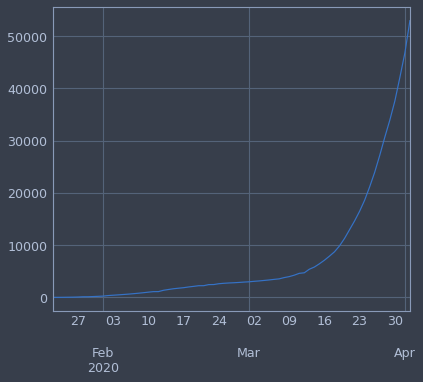

In [5]:
df2.T.sum().plot()

In [6]:
len(df2.columns)

181

In [7]:
df_exchina = df2.drop('China', 1)
df_exchina = df_exchina[df_exchina.T.sum() > 1]
len(df_exchina.columns)

180

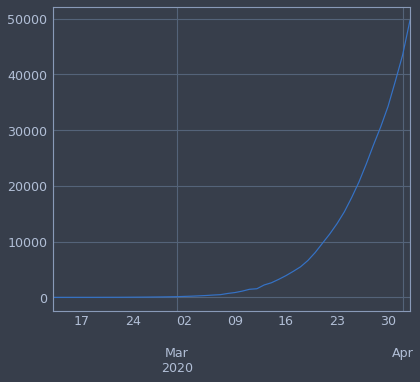

In [8]:
df_exchina.T.sum().plot()

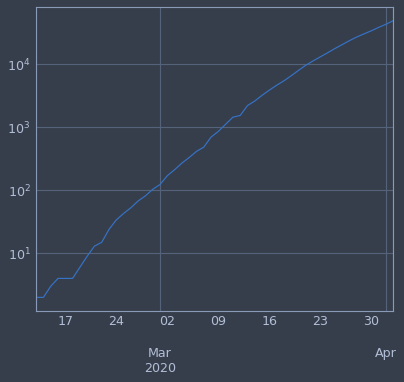

In [9]:
df_exchina.T.sum().plot(logy = True)

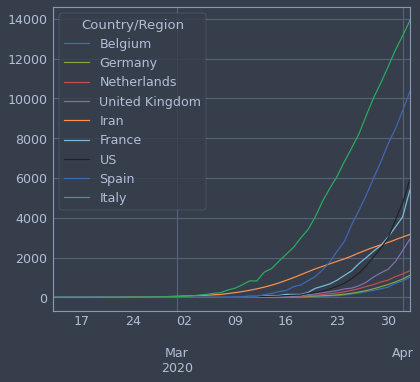

In [10]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot()

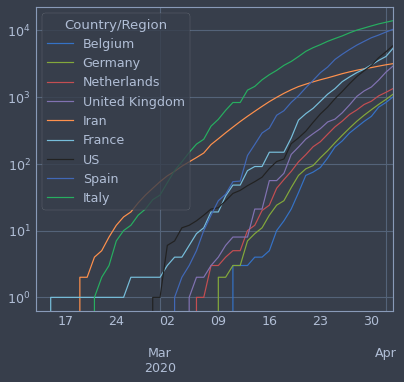

In [11]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot(logy = True)

In [27]:
df_exchina.T.sort_values(by=last_date).tail(9).T.tail(10)

Country/Region,Belgium,Germany,Netherlands,United Kingdom,Iran,France,US,Spain,Italy
2020-03-24,122,157,277,423,1934,1102,706,2808,6820
2020-03-25,178,206,357,466,2077,1333,942,3647,7503
2020-03-26,220,267,435,580,2234,1698,1209,4365,8215
2020-03-27,289,342,547,761,2378,1997,1581,5138,9134
2020-03-28,353,433,640,1021,2517,2317,2026,5982,10023
2020-03-29,431,533,772,1231,2640,2611,2467,6803,10779
2020-03-30,513,645,865,1411,2757,3030,2978,7716,11591
2020-03-31,705,775,1040,1793,2898,3532,3873,8464,12428
2020-04-01,828,920,1175,2357,3036,4043,4757,9387,13155
2020-04-02,1011,1107,1341,2926,3160,5398,5926,10348,13915


In [12]:
df_exchina.T.sort_values(by=last_date).tail(9).T.diff().tail(10)

Country/Region,Belgium,Germany,Netherlands,United Kingdom,Iran,France,US,Spain,Italy
2020-03-24,34.0,34.0,63.0,87.0,122.0,240.0,149.0,497.0,743.0
2020-03-25,56.0,49.0,80.0,43.0,143.0,231.0,236.0,839.0,683.0
2020-03-26,42.0,61.0,78.0,114.0,157.0,365.0,267.0,718.0,712.0
2020-03-27,69.0,75.0,112.0,181.0,144.0,299.0,372.0,773.0,919.0
2020-03-28,64.0,91.0,93.0,260.0,139.0,320.0,445.0,844.0,889.0
2020-03-29,78.0,100.0,132.0,210.0,123.0,294.0,441.0,821.0,756.0
2020-03-30,82.0,112.0,93.0,180.0,117.0,419.0,511.0,913.0,812.0
2020-03-31,192.0,130.0,175.0,382.0,141.0,502.0,895.0,748.0,837.0
2020-04-01,123.0,145.0,135.0,564.0,138.0,511.0,884.0,923.0,727.0
2020-04-02,183.0,187.0,166.0,569.0,124.0,1355.0,1169.0,961.0,760.0


In [13]:
def sigmoid(x, sat, td, velo):
    x = np.float64(x)
    
    td *= 1e10
    td *= 1e9
    
    real_sat = 1e5 * sat
    x = x - td
    x /= 1e14
    return real_sat / (1 + np.exp(-x * velo))

x = df_exchina.index
sat = 30000 / 1e5
td = time.time() / 1e10
velo = .1

In [14]:
popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_exchina.index, 
                       ydata = df_exchina.T.sum(), 
                       p0 = (sat, td, velo)
                      )

In [15]:
y_fit = sigmoid(x, *list(popt))

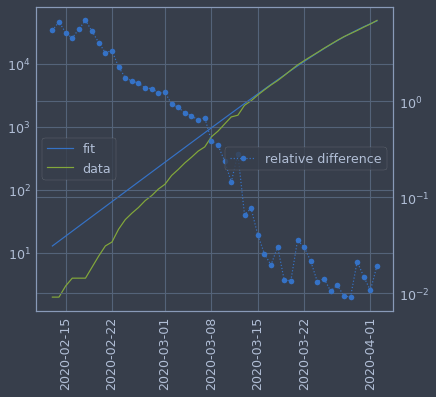

In [16]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)


ax1.semilogy(x, y_fit, label="fit")
ax1.semilogy(x, df_exchina.T.sum(), label="data")

ax2 = ax1.twinx()
ax2.semilogy(x, abs(y_fit - df_exchina.T.sum())/df_exchina.T.sum(), "o:", label="relative difference")
# ax1.legend(loc="lower left")
# ax2.legend(loc="center left")
ax1.legend(loc="center left")
ax2.legend(loc="center right")

In [17]:
th = datetime.datetime.fromtimestamp(popt[1] * 1e10)

In [18]:
f'The total number of Deaths outside China due to Covid-19 will be {int(popt[0] * 1e5)}. Half of those will be reached at {th.strftime("%Y-%B-%d %H:%M")}'

'The total number of Deaths outside China due to Covid-19 will be 106854. Half of those will be reached at 2020-April-03 01:38'

In [36]:
th - df_exchina.index[-1]

Timedelta('1 days 01:38:53.996840')

In [19]:
df_exchina.T.sum().tail()

2020-03-29    30621
2020-03-30    34274
2020-03-31    38798
2020-04-01    43493
2020-04-02    49661
dtype: int64

In [20]:
tstart = min(df_exchina.index)
tend = tstart + (th - tstart) * 2

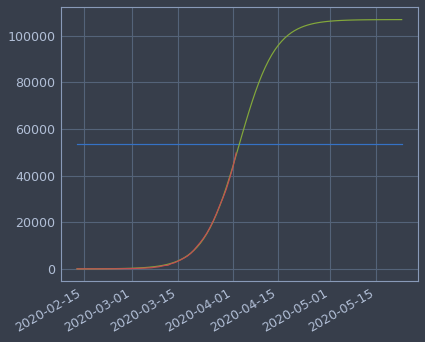

In [21]:
x_extra = np.arange(tstart, tend, datetime.timedelta(days=1)).astype('datetime64[ns]')
y_extra = sigmoid(x_extra, *list(popt))

plt.plot(x_extra, [popt[0]/2 * 1e5 for _ in x_extra])
plt.plot(x_extra, y_extra)
df_exchina.T.sum().plot()
plt.show()

In [22]:
df_exchina.T.sum().diff().tail()

2020-03-29    3268.0
2020-03-30    3653.0
2020-03-31    4524.0
2020-04-01    4695.0
2020-04-02    6168.0
dtype: float64

In [23]:
x = []
y_var = []
y = []
h = []

for e in df_exchina.index[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    
    x.append(e + datetime.timedelta(days=1))
    y_var.append(np.diag(pcov)[1] * 1e10)
    y.append(datetime.datetime.fromtimestamp(popt[1] * 1e10))
    h.append(int(popt[0] * 1e5))
    

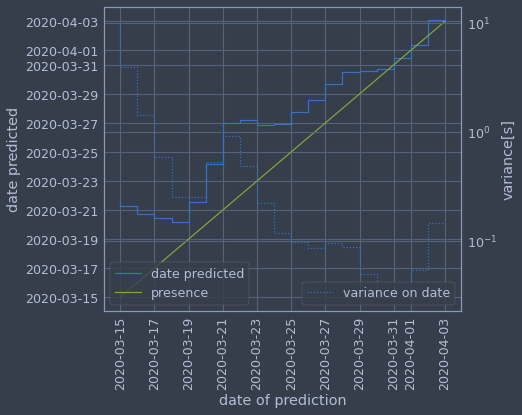

In [24]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
plt.xlabel("date of prediction")

plt.ylabel("date predicted")

ax1.plot(x, y, label='date predicted', drawstyle='steps')
ax1.plot(x, x, label='presence')


ax2 = ax1.twinx()
ax2.semilogy(x, y_var, ":", label='variance on date', drawstyle='steps')
plt.ylabel("variance[s]")

ax1.legend(loc="lower left")
ax2.legend(loc="lower right")

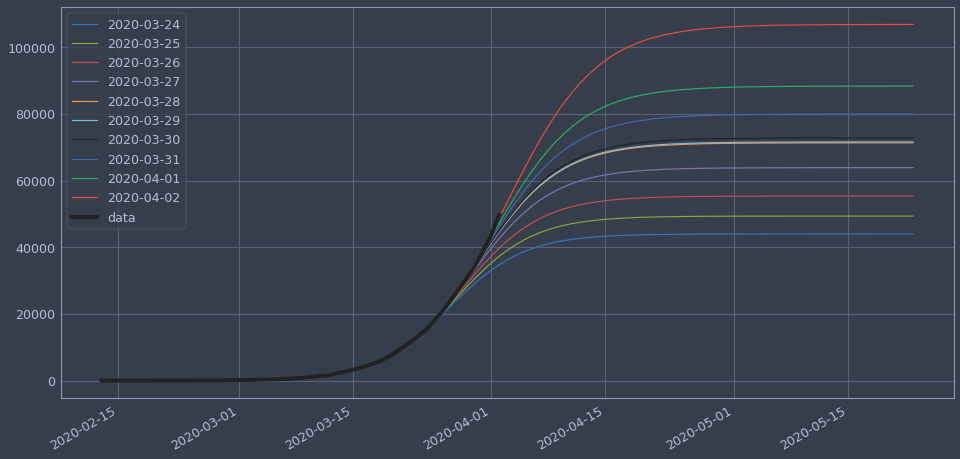

In [26]:
for e in df_exchina.index[-10:]:#[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    y_extra = sigmoid(x_extra, *list(popt))

    plt.plot(x_extra, y_extra, label=e.strftime("%Y-%m-%d"))
df_exchina.T.sum().plot(linewidth=4, style="k", label="data", figsize=(16,8))
plt.legend(loc="upper left")
plt.show()
    